# Synthetic Data generation (Part 1)


Synthetic data generation using large language models (LLMs) offers a powerful solution to a commonly faced problem: the availability of high-quality, diverse, and privacy-compliant data. This could be used in a number of scenarios such as training a data science  machine learning model (SVMs, decision trees, KNN's), finetuning a different GPT model on the data, as a solution to the coldstart problem, helping build compelling demos/apps with realistic data, scenario testing etc.

There are a number of key drivers which may see you wanting to leverage synthetic data. 
1. Human data may have privacy restrictions and/or identifiable data within it which we do not want to be used. 
2. Synthetic data can be much more structured and therefore easier to manipulate than real data. 
3. In domains where data is sparse or data of certain categories is sparse we may want to augment the data. 
4. When dealing with imbalanced datasets or datasets which lack diversity, we may want to create data to improve the richness of our datasets.

Unlike traditional data augmentation or manual data creation methods, using LLMs allows for the generation of rich, nuanced, and contextually relevant datasets that can significantly enhance it's usefulness to enterprises and developers.

We split this tutorial into 2 parts. In this cookbook, we will have the following agenda:
1. CSV with a structured prompt
2. CSV with a Python program
3. Multitable CSV with a python program
4. Simply creating textual data
5. Dealing with imbalanced or non-diverse textual data
while in part 2, we will look at prompting strategies for getting better textual data.

The last two in particular are useful for creating synthetic data to finetune another GPT model. For example using higher quality data produced by `gpt-4o` to finetune the cheaper and quicker `gpt-3.5-turbo` for improved performance while reducing costs.


### Getting setup

In [ ]:
%pip install openai
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

In [3]:
from openai import OpenAI
import os
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json
import matplotlib

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

### 1. CSV with a structure prompt
Here we create data in the simplest way. You can quickly generate data by addressing 3 key points: telling it the format of the data (CSV), the schema, and useful information regarding how columns relate (the LLM will be able to deduce this from the column names but a helping hand will improve performance).

In [4]:
datagen_model = "gpt-4o-mini"
question = """
Create a CSV file with 10 rows of housing data.
Each row should include the following fields:
 - id (incrementing integer starting at 1)
 - house size (m^2)
 - house price
 - location
 - number of bedrooms

Make sure that the numbers make sense (i.e. more rooms is usually bigger size, more expensive locations increase price. more size is usually higher price etc. make sure all the numbers make sense). Also only respond with the CSV.
"""

response = client.chat.completions.create(
  model=datagen_model,
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
    {"role": "user", "content": question}
  ]
)
res = response.choices[0].message.content
print(res)

```csv
id,house_size_m2,house_price,location,number_of_bedrooms
1,50,150000,Suburban,2
2,75,250000,City Center,3
3,100,350000,Suburban,4
4,120,450000,Suburban,4
5,80,300000,City Center,3
6,90,400000,City Center,3
7,150,600000,Premium Area,5
8,200,750000,Premium Area,5
9,55,180000,Suburban,2
10,300,950000,Premium Area,6
```


### 2. CSV with a Python program
The issue with generating data directly is we are limited in the amount of data we can generate because of the context. Instead what we can do is ask the LLM to generate a python program to generate the synthetic data. This allows us to scale to much more data while also providing us a view into how the data was generated by inspecting the python program.

This would then let us edit the python program as we desire while giving us a good basis to start from.


In [5]:
question = """
Create a Python program to generate 100 rows of housing data.
I want you to at the end of it output a pandas dataframe with 100 rows of data.
Each row should include the following fields:
 - id (incrementing integer starting at 1)
 - house size (m^2)
 - house price
 - location
 - number of bedrooms

Make sure that the numbers make sense (i.e. more rooms is usually bigger size, more expensive locations increase price. more size is usually higher price etc. make sure all the numbers make sense).
"""

response = client.chat.completions.create(
  model=datagen_model,
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
    {"role": "user", "content": question}
  ]
)
res = response.choices[0].message.content
print(res)

Certainly! Below is a Python program that generates synthetic housing data according to your specifications. We will create a pandas DataFrame with the defined fields and characteristics.

```python
import pandas as pd
import random

def generate_housing_data(num_rows):
    data = []
    
    locations = [
        ('City Center', 10000, 150),  # (location name, base price per m², base size)
        ('Suburban Area', 8000, 100),
        ('Country Side', 5000, 80),
        ('Coastal Region', 12000, 110),
        ('Urban Neighborhood', 9000, 130)
    ]
    
    for i in range(1, num_rows + 1):
        # Randomly pick a location
        location, base_price_per_m2, base_size = random.choice(locations)
        
        # Generate number of bedrooms (1 to 5)
        number_of_bedrooms = random.randint(1, 5)
        
        # Calculate house size based on the number of bedrooms
        house_size = base_size + (10 * number_of_bedrooms) + random.randint(-5, 15)  # Adding some noise
        
 

We need to make sure to parse the output of this appropriately as often there may be surrounding text to the python code. We can also explicitly ask it to state all assumptions it made about the data it's generating, however in this circumstance it told us that automatically.

### 3. Multitable CSV with a python program
For more complex relationships however we need to make sure to specify a few more characteristics. 

To create multiple different datasets which relate to each other (for example housing, location, house type), as before we would need to specify the format, schema and useful information. However, the useful information required to get good performance is higher now. It's case-specific but a good amount of things to describe would be how the datasets relate to each other, addressing the size of the datasets in relation to one another, making sure foreign and primary keys are made appropriately and ideally using previously generated datasets to populate new ones so the actual data values match where necessary.

In [6]:
question = """
Create a Python program to generate 3 different pandas dataframes.

1. Housing data
I want 100 rows. Each row should include the following fields:
 - id (incrementing integer starting at 1)
 - house size (m^2)
 - house price
 - location
 - number of bedrooms
 - house type
 + any relevant foreign keys

2. Location
Each row should include the following fields:
 - id (incrementing integer starting at 1)
 - country
 - city
 - population
 - area (m^2)
 + any relevant foreign keys

 3. House types
 - id (incrementing integer starting at 1)
 - house type
 - average house type price
 - number of houses
 + any relevant foreign keys

Make sure that the numbers make sense (i.e. more rooms is usually bigger size, more expensive locations increase price. more size is usually higher price etc. make sure all the numbers make sense).
Make sure that the dataframe generally follow common sense checks, e.g. the size of the dataframes make sense in comparison with one another.
Make sure the foreign keys match up and you can use previously generated dataframes when creating each consecutive dataframes.
You can use the previously generated dataframe to generate the next dataframe.
"""

response = client.chat.completions.create(
  model=datagen_model,
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
    {"role": "user", "content": question}
  ]
)
res = response.choices[0].message.content
print(res)

Certainly! Below is a Python program that generates the three specified pandas DataFrames for housing data, location data, and house types. Each DataFrame will include the necessary fields, and the foreign keys will ensure proper relationships among them.

```python
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(0)

# Function to generate location DataFrame
def generate_location_data(num_locations):
    locations = {
        "id": range(1, num_locations + 1),
        "country": np.random.choice(['USA', 'Canada', 'UK'], num_locations),
        "city": np.random.choice(['New York', 'Toronto', 'London', 'Vancouver', 'Manchester'], num_locations),
        "population": np.random.randint(50000, 1000000, num_locations),
        "area": np.random.randint(10000, 500000, num_locations)
    }
    return pd.DataFrame(locations)

# Function to generate house types DataFrame
def generate_house_type_data(num_house_types):
    house_types = {
        "id"

### 4. Simply creating textual data
Here we take a first look at creating textual data. This can be used to finetune another GPT model for example. In this case we imagine ourselves a retailer trying to streamline the process of creating descriptions for items they are selling. We again need to specify the format of the data, in particular in this case we want one which is easy to parse as an output.

The example we consider below is one in which we want to create input output training pairs for GPT model to finetune on. We will have the products' name and the category it belongs to as input and the output will be a description. 

Specifying the structure of the output explicitly and giving commands to not deviate from this help enforce the output structure. You can run this in a loop and append the data to generate more synthetic data. Again, as before we will need to parse the data well so that our code further downstream does not break.

In [7]:
output_string = ""
for i in range(3):
  question = f"""
  I am creating input output training pairs to fine tune my gpt model. The usecase is a retailer generating a description for a product from a product catalogue. I want the input to be product name and category (to which the product belongs to) and output to be description.
  The format should be of the form:
  1.
  Input: product_name, category
  Output: description
  2.
  Input: product_name, category
  Output: description

  Do not add any extra characters around that formatting as it will make the output parsing break.
  Create as many training pairs as possible.
  """

  response = client.chat.completions.create(
    model=datagen_model,
    messages=[
      {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
      {"role": "user", "content": question}
    ]
  )
  res = response.choices[0].message.content
  output_string += res + "\n" + "\n"
print(output_string[:1000]) #displaying truncated response


1.
Input: Wireless Bluetooth Headphones, Electronics
Output: Immerse yourself in high-quality sound with these Wireless Bluetooth Headphones, featuring active noise cancellation and a comfortable over-ear design for extended listening sessions.

2.
Input: Organic Green Tea, Beverages
Output: Enjoy a refreshing cup of Organic Green Tea, sourced from the finest leaves, packed with antioxidants, and perfect for a healthy, invigorating boost anytime.

3.
Input: Stainless Steel Kitchen Knife, Kitchenware
Output: Cut with precision and ease using this Stainless Steel Kitchen Knife, designed with an ergonomic handle and a sharp blade for all your culinary tasks.

4.
Input: Hiking Backpack, Outdoor Gear
Output: Explore the great outdoors with this durable Hiking Backpack, featuring multiple compartments for optimal organization and a breathable design for ultimate comfort on long treks.

5.
Input: Air Fryer, Kitchen Appliances
Output: Cook your favorite meals with less oil using this Air Fryer

Note: the above output is truncated. And now we can parse it as below to get a list of products, categories and their descriptions. For example, let's take a look at the products it's generated.

In [8]:
#regex to parse data
pattern = re.compile(r'Input:\s*(.+?),\s*(.+?)\nOutput:\s*(.+?)(?=\n\n|\Z)', re.DOTALL)
matches = pattern.findall(output_string)
products = []
categories = []
descriptions = []

for match in matches:
    product, category, description = match
    products.append(product.strip())
    categories.append(category.strip())
    descriptions.append(description.strip())
products

['Wireless Bluetooth Headphones',
 'Organic Green Tea',
 'Stainless Steel Kitchen Knife',
 'Hiking Backpack',
 'Air Fryer',
 "Kids' Educational Tablet",
 'Bluetooth Speaker',
 'Yoga Mat',
 'Memory Foam Mattress',
 'Smartwatch',
 'Leather Wallet',
 'Portable Phone Charger',
 'Non-Stick Cookware Set',
 'Pet Dog Bed',
 'Fitness Tracker',
 'Wireless Earbuds',
 'Organic Green Tea',
 'Reusable Water Bottle',
 'Yoga Mat',
 'Leather Wallet',
 'Air Fryer',
 'Gaming Mouse',
 'Crochet Kit',
 'Hiking Boots',
 'Scented Candles',
 'Bluetooth Speaker',
 'Stainless Steel Cookware Set',
 'Fitness Tracker',
 'Decorative Throw Pillows',
 'Eco-Friendly Cleaning Supplies',
 'Wireless Noise Cancelling Headphones',
 'Organic Green Tea',
 'Adjustable Yoga Mat',
 'Bluetooth Smart Scale',
 'Stainless Steel Water Bottle',
 'Soft Cotton Bedding Set',
 'Multi-Functional Kitchen Blender',
 'Eco-Friendly Reusable Bags',
 'Portable Phone Charger',
 'Classic Leather Wallet',
 'Suede Chelsea Boots',
 'Non-Stick Cookwar


### 5. Dealing with imbalanced or non-diverse textual data
Some of the most important aspects of generating high-quality synthetic data are accuracy (does the data make sense), consistency (are two separate data points for the same input roughly the same) and diversity (making sure our data distribution matches as much of the distribution that exists in production).


To increase the diversity of our data, we start first by clustering the data. This will provide us information about which clusters are underrepresented (imbalanced dataset) or which data is not addressed at all (widening the data distribution). Then, we will either suggest new clusters (using self-reflection type call from GPT) or ask the next iteration of our synthetic generation calls to explicitly target the underrepresented clusters. 

We can then recursively run this generation and analysis of cluster loop to automate generating diverse synthetic data.

For demonstrative purposes, we explicitly prompt the LLM to generate information about 4 different topical areas: vehicle, clothing, toiletries, food. We will then cluster the data and see if it managed to find these 4 topic areas.

In [19]:
output_string = ""
for i in range(3):
  question = f"""
  I am creating input output training pairs to fine tune my gpt model. I want the input to be product name and category and output to be description. the category should be things like: mobile phones, shoes, headphones, laptop, electronic toothbrush, etc. and also more importantly the categories should come under 4 main topics: vehicle, clothing, toiletries, food)
  After the number of each example also state the topic area. The format should be of the form:
  1. topic_area
  Input: product_name, category
  Output: description

  Do not add any extra characters around that formatting as it will make the output parsing break.

  Here are some helpful examples so you get the style of output correct.

  1) clothing
  Input: "Shoe Name, Shoes"
  Output: "Experience unparalleled comfort. These shoes feature a blend of modern style and the traditional superior cushioning, perfect for those always on the move."
  """

  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
      {"role": "user", "content": question}
    ]
  )
  res = response.choices[0].message.content
  output_string += res + "\n" + "\n"
print(output_string[:1000]) #displaying truncated response

1. vehicle  
Input: "Tesla Model 3, Electric Car"  
Output: "The Tesla Model 3 is a revolutionary electric car with impressive range and cutting-edge technology, designed to provide an exhilarating driving experience while minimizing environmental impact."

2. clothing  
Input: "Nike Air Max, Shoes"  
Output: "Elevate your sneaker game with Nike Air Max. Combining iconic style with superior comfort and support, these shoes are perfect for both workouts and casual outings."

3. toiletries  
Input: "Oral-B Pro 1000, Electronic Toothbrush"  
Output: "Achieve a superior clean with the Oral-B Pro 1000. This electronic toothbrush features 3D cleaning action that pulsates and oscillates to remove more plaque than a regular manual toothbrush."

4. food  
Input: "Chobani Greek Yogurt, Yogurt"  
Output: "Indulge in a nutritious snack with Chobani Greek Yogurt. Packed with protein and delicious flavors, it’s the perfect choice for a healthy breakfast or a satisfying treat anytime."

5. vehicle  


Note: The above output is truncated. In the example above, we would explicitly include the topic area as part of the response per example as it helps condition the proceeding output and tends to give better performance. We can also give it an actual example of what the output should look like so it gets the right idea of style of output but also to help enforce structure.

In [22]:
pattern = re.compile(r'(\d+)\.\s*(\w+)\s*Input:\s*"(.+?),\s*(.+?)"\s*Output:\s*"(.*?)"', re.DOTALL)
matches = pattern.findall(output_string)

topics = []
products = []
categories = []
descriptions = []

for match in matches:
    number, topic, product, category, description = match
    topics.append(topic)
    products.append(product)
    categories.append(category)
    descriptions.append(description)


In [23]:
products

['Tesla Model 3',
 'Nike Air Max',
 'Oral-B Pro 1000',
 'Chobani Greek Yogurt',
 'Ford F-150',
 "Levi's 511",
 'Philips Sonicare',
 'Quaker Oatmeal',
 'Toyota Camry',
 'Adidas Ultraboost',
 'Toyota Camry',
 'Nike Air Max',
 'Colgate Electric Toothbrush',
 'Blue Diamond Almonds',
 'Harley Davidson Fat Boy',
 'Adidas UltraBoost',
 "Dove Men's Body Wash",
 'Quaker Oats',
 'Ford F-150',
 "Levi's 501 Jeans",
 'Tesla Model 3',
 'Nike Air Max',
 'Oral-B Pro 1000',
 'Organic Almond Butter',
 'Yamaha YZF-R3',
 'Adidas Ultraboost',
 'Philips Sonicare',
 'Organic Quinoa']

We will now cluster the data to analyze it. We will use K-means clustering to segregate the data. An important parameter of K-means to set is K, the number of clusters.

We know that there should be 4 cluster (4 topics) since we specified this in prompt: vehicle, electronics, clothing, food. However in general for our data, we do not know the number of clusters that exist. Therefore we will use the elbow method to find the optimal number of clusters.

In the elbow method, we iterate through a range of different K's, each time storing the inertia. The inertia measures the sum of the squared distances between each point in a cluster and the centroid of that cluster thus telling us how well-separated and dense each cluster is. If we plot K against the inertia, we are able to see how the inertia drops and where the drop in inertia is least rapid (often making an elbow shape) we can set our optimal number of clusters. You can read into more depth about the elbow method [here](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

First let's store our data into a pandas dataframe for ease of analysis



In [24]:
data = {
    'Product': products,
    'Category': categories,
    'Description': descriptions
}

df = pd.DataFrame(data)

Next let us embed our data as the embeddings is what we will cluster since they should be close to each other in vector space if they are similar.

In [25]:
def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")

    response = client.embeddings.create(input=[text], model=model)

    return response.data[0].embedding

embedding_model = "text-embedding-3-small"
df["embedding"] = df.Category.apply(lambda x: get_embedding(x, model=embedding_model))

# Ensure there are embeddings to concatenate
if len(df.embedding.values) > 0:
    matrix = np.vstack(df.embedding.values)
else:
    matrix = np.array([])  # Handle the case where there are no embeddings


In [26]:
df

,Product,Category,Description,embedding
0,Tesla Model 3,Electric Car,The Tesla Model 3 is a revolutionary electric ...,"[0.003255360759794712, -0.039260633289813995, ..."
1,Nike Air Max,Shoes,Elevate your sneaker game with Nike Air Max. C...,"[0.03943369910120964, 0.022045187652111053, -0..."
2,Oral-B Pro 1000,Electronic Toothbrush,Achieve a superior clean with the Oral-B Pro 1...,"[-0.003470012918114662, -0.01911414973437786, ..."
3,Chobani Greek Yogurt,Yogurt,Indulge in a nutritious snack with Chobani Gre...,"[0.0208318829536438, -0.02645781636238098, -0...."
4,Ford F-150,Pickup Truck,"The Ford F-150 is the ultimate pickup truck, d...","[0.007467855699360371, -0.05288049206137657, -..."
5,Levi's 511,Jeans,Step out in style with Levi's 511 jeans. Featu...,"[0.0037206460256129503, 0.022772302851080894, ..."
6,Philips Sonicare,Electric Toothbrush,Discover a new level of oral care with the Phi...,"[-0.00724813062697649, -0.011600878089666367, ..."
7,Quaker Oatmeal,Breakfast Cereal,Start your day right with Quaker Oatmeal. This...,"[-0.006529285106807947, 0.007865572348237038, ..."
8,Toyota Camry,Sedan,The Toyota Camry stands out in the sedan categ...,"[-0.02088991366326809, -0.006191295105963945, ..."
9,Adidas Ultraboost,Running Shoes,Run like never before in the Adidas Ultraboost...,"[0.02679188922047615, 0.014639599248766899, 8...."


Now we perform the elbow method. 

In [27]:
# Determine the optimal number of clusters using the elbow method
inertias = []
range_of_clusters = range(1, 13)  # Adjust the range as necessary

for n_clusters in range_of_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10)
    kmeans.fit(matrix)
    inertias.append(kmeans.inertia_)


This will output a chart for us in which we have to visually tell where the optimal cluster point is. We can see below that we see a gradual decrease of inertia rather than a sharp elbow but the point of steepest decrease appears to occur around 3, 4 or 5 clusters which lines up with our expectations given our prompt. 

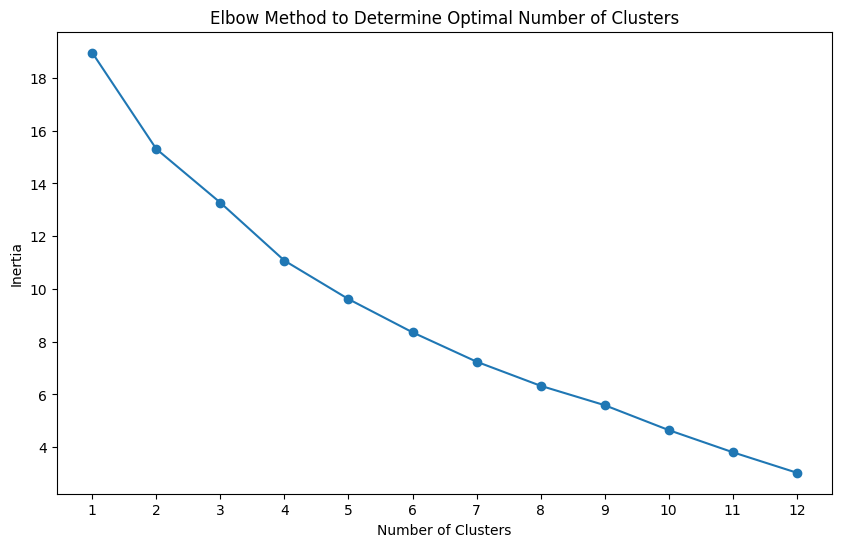

In [28]:
# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, inertias, '-o')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range_of_clusters)
plt.show()

![elbow_chart](../images/elbow_chart.png)

For demonstration purposes we will pick 5 as the optimal cluster number to show it doesn't matter exactly where we pick it as long as we are approximately right. There are numerous correct ways to categorize data. We also store which cluster each data point belongs to.

In [29]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

We will analyze the cluster data now. There are two separate things we will look to address. 1. imbalanced data, 2. Expanding the data distribution.

First for imbalanced data we count the number of examples in each cluster. Then we select a few examples from each cluster at random and ask the LLM what topics these map to. 

In [30]:
cluster_counts = df["Cluster"].value_counts().sort_index()
print(cluster_counts)

Cluster
0    5
1    7
2    8
3    6
4    2
Name: count, dtype: int64


We can see the topics found here:
Eco-friendly Transportation, Luxury and Leisure Items, Personal Care Products, Electronic Toothbrushes and Clothing and Apparel
match well enough but not exactly to our initial prompt of:
vehicle, clothing, toiletries, food.

As we chose 5 clusters, it split up toiletries into Skincare and Personal Care which doesn't affect us too much further downstream.

In [33]:
df

,Product,Category,Description,embedding,Cluster
0,Tesla Model 3,Electric Car,The Tesla Model 3 is a revolutionary electric ...,"[0.003255360759794712, -0.039260633289813995, ...",1
1,Nike Air Max,Shoes,Elevate your sneaker game with Nike Air Max. C...,"[0.03943369910120964, 0.022045187652111053, -0...",2
2,Oral-B Pro 1000,Electronic Toothbrush,Achieve a superior clean with the Oral-B Pro 1...,"[-0.003470012918114662, -0.01911414973437786, ...",1
3,Chobani Greek Yogurt,Yogurt,Indulge in a nutritious snack with Chobani Gre...,"[0.0208318829536438, -0.02645781636238098, -0....",3
4,Ford F-150,Pickup Truck,"The Ford F-150 is the ultimate pickup truck, d...","[0.007467855699360371, -0.05288049206137657, -...",0
5,Levi's 511,Jeans,Step out in style with Levi's 511 jeans. Featu...,"[0.0037206460256129503, 0.022772302851080894, ...",2
6,Philips Sonicare,Electric Toothbrush,Discover a new level of oral care with the Phi...,"[-0.00724813062697649, -0.011600878089666367, ...",1
7,Quaker Oatmeal,Breakfast Cereal,Start your day right with Quaker Oatmeal. This...,"[-0.006529285106807947, 0.007865572348237038, ...",3
8,Toyota Camry,Sedan,The Toyota Camry stands out in the sedan categ...,"[-0.02088991366326809, -0.006191295105963945, ...",0
9,Adidas Ultraboost,Running Shoes,Run like never before in the Adidas Ultraboost...,"[0.02679188922047615, 0.014639599248766899, 8....",2


In [36]:
selected_examples = df.groupby('Cluster').apply(lambda x: x.sample(3, replace=True)).reset_index(drop=True)

# Format the selected examples
formatted_examples = "\n".join(
    f'Input: "{row["Product"]}, {row["Category"]}"\nOutput: "{row["Description"]}"\nCluster: "{row["Cluster"]}"'
    for _, row in selected_examples.iterrows()
)

topic_prompt = f"""
    I previously generated some examples of input output trainings pairs and then I clustered them based on category. From each cluster I picked 3 example data point which you can find below.
    I want you identify the broad topic areas these clusters belong to.
    Previous examples:
    {formatted_examples}


    Your output should be strictly of the format:
    Cluster: number, topic: topic
    Cluster: number, topic: topic
    Cluster: number, topic: topic

    Do not add any extra characters around that formatting as it will make the output parsing break.
    """

response = client.chat.completions.create(
  model=datagen_model,
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed analyze clustered data"},
    {"role": "user", "content": topic_prompt}
  ]
)
res = response.choices[0].message.content

pattern = r"Cluster: (\d+), topic: ([^\n]+)"
matches = re.findall(pattern, res)
clusters = [{"cluster": int(cluster), "topic": topic} for cluster, topic in matches]
json_output = json.dumps(clusters, indent=2)
print(json_output)

[
  {
    "cluster": 0,
    "topic": "Automotive  "
  },
  {
    "cluster": 1,
    "topic": "Personal Care  "
  },
  {
    "cluster": 2,
    "topic": "Footwear  "
  },
  {
    "cluster": 3,
    "topic": "Food  "
  },
  {
    "cluster": 4,
    "topic": "Automotive  "
  }
]


We now have the clusters and their counts so we could prompt the LLM to generate more examples within the topics we want. However for this example we won't take that further as they are well-split and you would just follow the procedure above for prompting the model to generate data while passing in the underrepresented topics.

Next, we will try and deal with increasing the diversity of our data distribution. 

First we start in a similar way by finding a few examples from each cluster at random and ask the LLM what topics these map to. In addition to this in the same LLM call, we will ask it to generate more topics to increase the diversity of our data. We do this in one call to save time/cost.

In [37]:
selected_examples = df.groupby('Cluster').apply(lambda x: x.sample(3, replace=True)).reset_index(drop=True)

# Format the selected examples
formatted_examples = "\n".join(
    f'Input: "{row["Product"]}, {row["Category"]}"\nOutput: "{row["Description"]}"\nCluster: "{row["Cluster"]}"'
    for _, row in selected_examples.iterrows()
)

topic_prompt = f"""
    I previously generated some examples of input output trainings pairs and then I clustered them based on category. From each cluster I picked 3 example data point which you can find below.
    I want to promote diversity in my examples across categories so follow the procedure below:
    1. You must identify the broad topic areas these clusters belong to.
    2. You should generate further topic areas which don't exist so I can generate data within these topics to improve diversity.


    Previous examples:
    {formatted_examples}


    Your output should be strictly of the format:

    1. Cluster topic mapping
    Cluster: number, topic: topic
    Cluster: number, topic: topic
    Cluster: number, topic: topic

    2. New topics
    1. topic
    2. topic
    3. topic
    4. topic

    Do not add any extra characters around that formatting as it will make the output parsing break. It is very important you stick to that output format
    """

response = client.chat.completions.create(
  model=datagen_model,
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to analyze clustered data"},
    {"role": "user", "content": topic_prompt}
  ]
)
res = response.choices[0].message.content
print(res)


1. Cluster topic mapping
Cluster: 0, topic: Automotive
Cluster: 1, topic: Personal Care
Cluster: 2, topic: Footwear
Cluster: 3, topic: Food
Cluster: 4, topic: Electric Vehicles

2. New topics
1. topic: Home Appliances
2. topic: Outdoor Equipment
3. topic: Smart Home Technology
4. topic: Fitness Equipment


We can see here again that we explicitly prompt the output structure it should follow. I also tell it the purpose of generating topics (to promote diversity) so the model has full context.

We then parse the data into a list of cluster-mapping jsons and a list of topics

In [38]:
parts = res.split("\n\n")
cluster_mapping_part = parts[0]
new_topics_part = parts[1]

# Parse cluster topic mapping
cluster_topic_mapping_lines = cluster_mapping_part.split("\n")[1:]  # Skip the first two lines
cluster_topic_mapping = [{"cluster": int(line.split(",")[0].split(":")[1].strip()), "topic": line.split(":")[2].strip()} for line in cluster_topic_mapping_lines]

# Parse new topics
new_topics_lines = new_topics_part.split("\n")[1:]  # Skip the first line
new_topics = [line.split(". ")[1] for line in new_topics_lines]

cluster_topic_mapping, new_topics

([{'cluster': 0, 'topic': 'Automotive'},
  {'cluster': 1, 'topic': 'Personal Care'},
  {'cluster': 2, 'topic': 'Footwear'},
  {'cluster': 3, 'topic': 'Food'},
  {'cluster': 4, 'topic': 'Electric Vehicles'}],
 ['topic: Home Appliances',
  'topic: Outdoor Equipment',
  'topic: Smart Home Technology',
  'topic: Fitness Equipment'])

And finally we can use this information to further prompt a model to keep generating synthetic data. We do this by passing all the topics in the list of jsons to the prompt below.

In [39]:
output_string = ""
for i in range(3):
  question = f"""
  I am creating input output training pairs to fine tune my gpt model. I want the input to be product name and category and output to be description. the category should be things like: mobile phones, shoes, headphones, laptop, electronic toothbrush, etc. and also more importantly the categories should come under some main topics: {[entry['topic'] for entry in cluster_topic_mapping]})
  After the number of each example also state the topic area. The format should be of the form:
  1. topic_area
  Input: product_name, category
  Output: description

  Do not add any extra characters around that formatting as it will make the output parsing break.

  Here are some helpful examples so you get the style of output correct.

  1) clothing
  Input: "Shoe Name, Shoes"
  Output: "Experience unparalleled comfort. These shoes feature a blend of modern style and the traditional superior cushioning, perfect for those always on the move."
  """

  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
      {"role": "user", "content": question}
    ]
  )
  res = response.choices[0].message.content
  output_string += res + "\n" + "\n"
print(output_string)

1. Automotive  
Input: "Tesla Model S, Electric Vehicles"  
Output: "The Tesla Model S delivers exhilarating performance with advanced electric technology, offering a sleek design, impressive range, and an industry-leading infotainment system."

2. Personal Care  
Input: "Oral-B Pro 1000, Electronic Toothbrush"  
Output: "The Oral-B Pro 1000 features a 3D cleaning action that oscillates, rotates, and pulsates to remove plaque, ensuring a deeper clean for healthier gums."

3. Footwear  
Input: "Nike Air Max 270, Shoes"  
Output: "Step into comfort and style with Nike Air Max 270, designed with a large Max Air unit for superior cushioning and a breathable upper for a snug fit."

4. Electronics  
Input: "Apple iPhone 12, Mobile Phones"  
Output: "The Apple iPhone 12 combines powerful performance with stunning design, equipped with A14 Bionic chip and advanced camera systems for capturing every moment in stunning detail."

5. Food  
Input: "Nature Valley Granola Bars, Snacks"  
Output: "Na

You can run this in a loop to append to your previous data and in this way you can keep generating more textual synthetic data to train another GPT model while making sure that we cater to imbalanced datasets and generating a diversity of data.

You have now completed part 1 of the synthetic data generation tutorial where we have gone through:
*   CSV with a structured prompt
*   CSV with a Python program
*   Multitable CSV with a python program
*   Simply creating textual data
*   Dealing with imbalanced or non-diverse textual data

In part 2 you will find find out techniques for better prompting an LLM to enhance textual synthetic data generation.